In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
import torchvision
import torchvision.transforms
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
from torch.utils.data import DataLoader
from torchsummary import summary
from IPython.core.debugger import set_trace

from Tools import Trainer

## Loading datasets

In [2]:
from Tools.Dataloader import datasets_loader

normalize = torchvision.transforms.Normalize((0.4895832, 0.4546405, 0.41594946), 
                                (0.2520022, 0.24522494, 0.24728711))
train_val_transforms = torchvision.transforms.Compose([
                            torchvision.transforms.RandomCrop(64),
                            torchvision.transforms.RandomHorizontalFlip(),
                            torchvision.transforms.ToTensor(),
                            normalize])

norm_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                normalize])       
                                                  
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.FiveCrop(64), # this is a list of PIL Images
    torchvision.transforms.Lambda(lambda crops: torch.stack([norm_transforms(crop) for crop in crops])), # returns a 4D tensor
])
                                                  
train_loader, valid_loader, test_loader = datasets_loader(train_val_transforms, test_transforms)

In [3]:
print(train_loader.dataset.dataset)
print(test_loader.dataset)

Dataset ImageFolder
    Number of datapoints: 19998
    Root Location: ./data/trainset/
    Transforms (if any): Compose(
                             RandomCrop(size=(64, 64), padding=0)
                             RandomHorizontalFlip(p=0.5)
                             ToTensor()
                             Normalize(mean=(0.4895832, 0.4546405, 0.41594946), std=(0.2520022, 0.24522494, 0.24728711))
                         )
    Target Transforms (if any): None


## Hyper-parameters

In [4]:
hyperparams = {'num_epochs': 30,
               'lr0' :0.1, 
               'dropout':0.2,
               'gamma': 1,
               'adjust_lr': False,
               'save_checkpoint': True      
                  }
cuda_available = torch.cuda.is_available()

## Creating the model

In [5]:
from Classifier.XavierCNN import XavierDropout

model = XavierDropout(hyperparams)
if cuda_available:
    model = model.cuda()

optimizer = torch.optim.SGD(model.parameters(), lr=hyperparams['lr0'])
criterion = nn.CrossEntropyLoss()

In [6]:
summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
              ReLU-2           [-1, 16, 64, 64]               0
   GaussianDropout-3           [-1, 16, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           4,640
              ReLU-5           [-1, 32, 64, 64]               0
         MaxPool2d-6           [-1, 32, 32, 32]               0
   GaussianDropout-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          18,496
              ReLU-9           [-1, 64, 32, 32]               0
  GaussianDropout-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]          73,856
             ReLU-12          [-1, 128, 32, 32]               0
  GaussianDropout-13          [-1, 128, 32, 32]               0
        MaxPool2d-14          [-1, 128,

## Training 

In [7]:
from Tools.Trainer import Trainer

trainer = Trainer(model, optimizer, criterion, train_loader, valid_loader, test_loader, hyperparams)
nll_train, nll_valid, acc_train, acc_valid =  trainer.train_model()
print('Done...')

------ Epoch # 1 ------
 Iteration 40: TRAIN 0.6929
 Iteration 80: TRAIN 0.6910
 Iteration 120: TRAIN 0.6896
------ Epoch # 2 ------
 Iteration 160: TRAIN 0.6828
 Iteration 200: TRAIN 0.6801
 [Loss] TRAIN 0.6729 / VALID 0.6752
 [ACC] TRAIN 0.5870 / VALID 0.5756
new checkpoint is saved!
 Iteration 240: TRAIN 0.6780
 Iteration 280: TRAIN 0.6750
------ Epoch # 3 ------
 Iteration 320: TRAIN 0.6627
 Iteration 360: TRAIN 0.6644
 Iteration 400: TRAIN 0.6557
 [Loss] TRAIN 0.6424 / VALID 0.6547
 [ACC] TRAIN 0.6222 / VALID 0.5966
new checkpoint is saved!
 Iteration 440: TRAIN 0.6494
------ Epoch # 4 ------
 Iteration 480: TRAIN 0.6358
 Iteration 520: TRAIN 0.6281
 Iteration 560: TRAIN 0.6177
------ Epoch # 5 ------
 Iteration 600: TRAIN 0.6127
 [Loss] TRAIN 0.5958 / VALID 0.6088
 [ACC] TRAIN 0.6982 / VALID 0.6827
new checkpoint is saved!
 Iteration 640: TRAIN 0.6059
 Iteration 680: TRAIN 0.6011
 Iteration 720: TRAIN 0.5872
------ Epoch # 6 ------
 Iteration 760: TRAIN 0.5758
 Iteration 800: TRA

## Visualization

### accuracy and loss plots

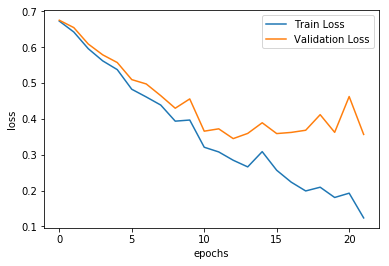

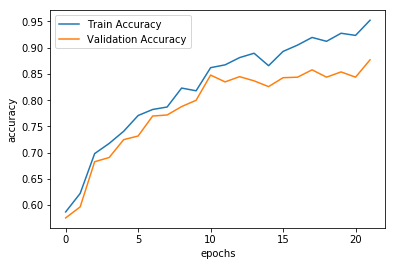

In [8]:
import Tools.Visualization as V
V.plots(nll_train, nll_valid, acc_train, acc_valid)

### Confusion Matrix

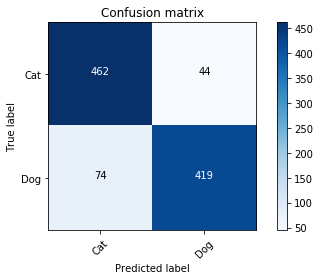

In [9]:
import Tools.Visualization as V
cnf_matrix = trainer.confusion_matrix()
V.plot_confusion_matrix(cnf_matrix)

## Saving the model

In [57]:
torch.save(model, "./Experiments/Xavier-Dropout-augmented-89.5")

## Generate Submission

In [11]:
# import Tools.Trainer as T
# results = T.predict_test_set_5crop(model, test_loader)
# print(results.size())
# T.generate_submission(results)

Done...


In [53]:
def predict_test_set_5crop(model, test_loader):
    results = [[]]
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()
        bs, ncrops, c, h, w = inputs.size()
        result = model(inputs.view(-1, c, h, w)) # fuse batch size and ncrops
        result_avg = result.view(bs, ncrops, -1).mean(1) # avg over crops
        _, result_avg = torch.max(result_avg, 1)
        results = np.append(results, result_avg.cpu().detach().numpy())
    results = np.int8(results)
    return results

In [54]:
results = predict_test_set_5crop(model, test_loader)
print(results.shape)

(4999,)


In [56]:
T.generate_submission(results)

Done...
